# Test Bias Simulation   
I Analyzed the Unbias trajectory performing the Deep-TICA Analysis, in order to find the slow modes of the system.  
Using a lag time $\tau = 1$ I obtained a first Deep-TICA able to distinguish the two basins inside the lowest basin A, but the second Deep-TICA is  noisy in the $\phi$-$\psi$ plane.  
Then I performed a simulation with these CVs, but after $100$ $ns$ a transition between basin A and B never happened. (I performed the simulation biasing initially both, and then only the first one).    

------------------------------------------------
  
One can obtain few transitions biasing along the CVs obtained from the analysis of unbias trajectory with a lag time $\tau=10$. Biasing both (`Bias.ipynb`) few transitions occured.  
At first it seems that the transions happend due to the second Deep-TICA, which is possible. But in `Different_seeds_Unbias.ipnyb` I evaluate these 2 CVs for different seeds, and not always the obtained CVs are similar. Especially the second one, indicating that it comes from noise.  
Biasing just along the first CV only one transition occurs.  

------------------------------------------------

In this jupyter I analyze different simulation biasing along CVs trained with different lag times and seeds. In particular I will focus my self on the two lag times for which the gap between eigenvalues is maximum: $\tau = 4$ and $\tau = 10$   

## Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import integrate

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- reading multiple files from the same folder --#
import glob

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# load data from simulation

In [3]:
lag = 10
container = glob.glob("test_different_seeds/lag"+str(lag)+"/bias1_seed*")

data_complete = load_dataframe("angles/COLVAR")
descriptors_names = data_complete.filter(regex='^d[^a-z]').columns.values
X_complete = data_complete[descriptors_names].to_numpy()


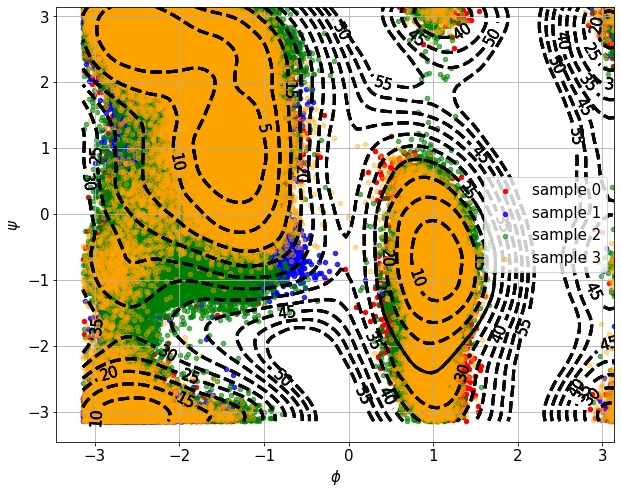

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
k=0
color = ["r","b","g","orange"]
alpha = [1,0.8,0.6,0.4]
for folder in container:
    load_dataframe(folder+"/COLVAR").plot.scatter(y="psi",x="phi",ax=ax,label="sample "+str(k),c=color[k],alpha=alpha[k])
    fes = np.loadtxt("angles/fes.txt",delimiter=" ")
    grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
    grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
    bounds = np.arange(0, 60, 5.)
    c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c.clabel()
    ax.grid()
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    k+=1

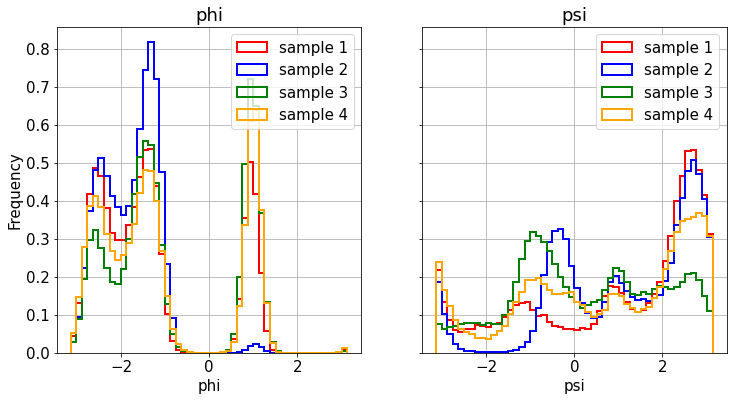

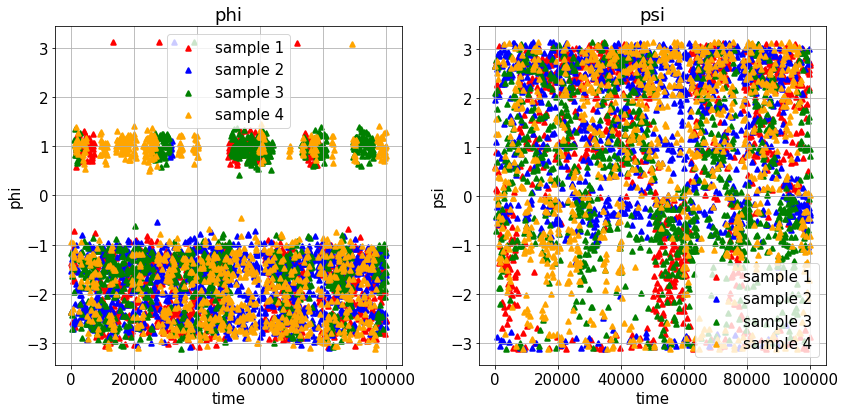

In [7]:
fig1,axs1 = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig2,axs2 = plt.subplots(1,2,figsize=(12,6))#,sharey=True)
k=0
for folder in container:
    data = load_dataframe(folder+"/COLVAR")
    descriptors_names = data.filter(regex='^p').columns.values

    for ax,desc in zip(axs1.flatten(),descriptors_names):
        data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True,color=color[k],label="sample "+str(k+1))
        #data[desc].plot.hist(bins=50,alpha=alpha[k],ax=ax,grid=True,color=color[k],density=True,label="sample "+str(k+1))
        ax.set_title(desc)
        ax.set_xlabel(desc)
        ax.legend()
 
    for ax,desc in zip(axs2.flatten(),descriptors_names):
        data[::100].plot.scatter(x="time",y=desc,alpha=1,ax=ax,grid=True,linewidth=2,marker="^",label="sample "+str(k+1),color=color[k])
        #data[::100].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color=color[k])
        ax.set_title(desc)
        ax.set_ylabel(desc)
        ax.legend()
    k+=1

    plt.tight_layout()

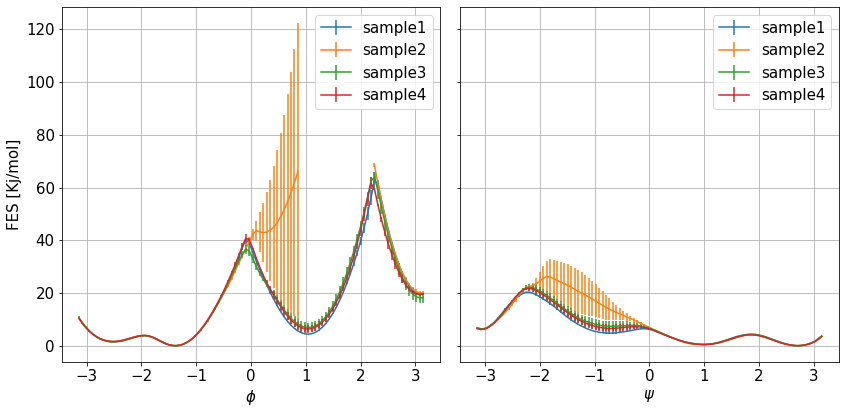

In [6]:
#-- estimation of Free Energy Surface --#
fig, axs = plt.subplots(1,2,figsize=(12,6),sharey=True)

for folder in container:
    s = load_dataframe(folder+"/COLVAR").filter(regex="^p").to_numpy()
    logweight = np.transpose( load_dataframe(folder+"/COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
    logweight = logweight - np.max(logweight)

    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = axs[i])

for i in range(2):
    axs[i].legend(["sample1","sample2","sample3","sample4"])   
    axs[i].grid()
    axs[i].set_ylabel("")
axs[0].set_ylabel("FES [Kj/mol]")
axs[0].set_xlabel(r"$\phi$")
axs[1].set_xlabel(r"$\psi$")
plt.tight_layout()